Load the photometry data
Load the behavior data
Downsample the behavior data to match the photometry data's sampling rate
Align the two datasets, given they start recording at the same time but have different ending times
Apply Gaussian filtering and Z-score normalization to the processed photometry data
Plot the photometry data
Overlay the plot with markers indicating when the reward occurred, based on the behavior data (water_valve > 4)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from nptdms import TdmsFile
import scipy.stats
import scipy.signal
from scipy.optimize import curve_fit
import pandas as pd
from scipy import signal
import os
import scipy.ndimage
import scipy.stats
# from sklearn.metrics import r2_score
import scipy.ndimage
import scipy.stats


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data 
def import_photometry_data_for_mouse_and_day(directory, mouse_id, day_of_interest):
    """
    Reads photometry data for a specific mouse on a specified day from a TDMS file,
    providing direct access to the signal data for analysis.

    Parameters:
    - directory: The path to the directory containing the TDMS files.
    - mouse_id: The ID of the mouse (e.g., 'maxwell_452').
    - day_of_interest: An integer representing the day of interest.

    Returns:
    A dictionary of channels mapping directly to their data arrays for the specified mouse and day.
    If the file does not exist or cannot be read, returns None.
    """
    filename = os.path.join(directory, f"{mouse_id}_day{day_of_interest}.tdms")
    if not os.path.exists(filename):
        print(f"File {filename} does not exist.")
        return None

    try:
        tdms_file = TdmsFile.read(filename)
    except Exception as e:
        print(f"Failed to read {filename}: {e}")
        return None

    channels_data = {}
    for group in tdms_file.groups():
        for channel in group.channels():
            channel_name = channel.name
            data = channel[:]
            channels_data[channel_name] = data

    return channels_data


In [3]:
import pandas as pd
import scipy.ndimage
import scipy.stats

def process_signals_and_save_to_dataframe(data, mouse_id, day_of_interest, sigma=20):
    """
    Processes the entire session's signals for PFC and HPC channels from the given data,
    applying Gaussian filtering and z-score normalization, and saves them into separate DataFrames.

    Parameters:
    - data: Dictionary containing the channel data, expected to be the output from the `import_photometry_data_for_mouse_and_day` function.
    - mouse_id: The ID of the mouse.
    - day_of_interest: The day of interest.
    - sigma: The sigma value for the Gaussian filter.

    Returns:
    Two pandas DataFrames, one for the HPC channel and one for the PFC channel,
    containing the processed signals for the entire session.
    """
    processed_signals = {'PFC': None, 'HPC': None}

    for channel_name, label in [('Voltage_0 (Filtered)', 'PFC'),
                                ('Voltage_1 (Filtered)', 'HPC')]:
        if channel_name in data:
            signal = data[channel_name]
            signal_filtered = scipy.ndimage.gaussian_filter1d(signal, sigma=sigma)
            signal_zscored = scipy.stats.zscore(signal_filtered)
            processed_signals[label] = pd.DataFrame(signal_zscored, columns=[f"{label} Z-scored Signal"])

    return processed_signals['PFC'], processed_signals['HPC']


# Running for generating dataframes for each processed signals for HPC and PFC

In [4]:
directory = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry'  # Example directory where your TDMS files are located
mouse_id = 'maxwell_453'  # Example mouse ID
day_of_interest = 12  # Example day of interest

# Import the data
channel_data = import_photometry_data_for_mouse_and_day(directory, mouse_id, day_of_interest)

if channel_data is not None:
    # Process the signals and save to DataFrames
    pfc_df, hpc_df = process_signals_and_save_to_dataframe(channel_data, mouse_id, day_of_interest)

    # Example of how you can use the DataFrames
    print(pfc_df.head())  # Display the first few rows of the PFC DataFrame
    print(hpc_df.head())  # Display the first few rows of the HPC DataFrame
else:
    print("Data import failed, please check the file path and the file format.")

   PFC Z-scored Signal
0           -34.257407
1           -34.163067
2           -33.975003
3           -33.694443
4           -33.323210
   HPC Z-scored Signal
0           -28.950993
1           -28.872397
2           -28.715714
3           -28.481963
4           -28.172656


In [5]:
pfc_df.shape

(754250, 1)

In [6]:
pfc_df.head()

,PFC Z-scored Signal
0,-34.257407
1,-34.163067
2,-33.975003
3,-33.694443
4,-33.323210


In [7]:
hpc_df.shape

(754250, 1)

In [8]:
# Reset the index so that the concatenation does not depend on the DataFrame's original indices
hpc_df = hpc_df.reset_index(drop=True)
pfc_df = pfc_df.reset_index(drop=True)

# Now concatenate them side by side
all_signal_df = pd.concat([hpc_df, pfc_df], axis=1)
all_signal_df.shape

(754250, 2)

# All the plotting stuff are below

In [9]:
#now we want to add another columns that indicates when the reward is delivered, odour etc
all_signal_df

,HPC Z-scored Signal,PFC Z-scored Signal
0,-28.950993,-34.257407
1,-28.872397,-34.163067
2,-28.715714,-33.975003
3,-28.481963,-33.694443
4,-28.172656,-33.323210
...,...,...
754245,-0.697115,-0.962608
754246,-0.696685,-0.963347
754247,-0.696361,-0.963897
754248,-0.696142,-0.964260


In [10]:
def find_water_valve_rises(water_valve_signal):
    # Identifying water valve rises from behavior data (NumPy array)
    return np.where(np.diff(water_valve_signal > 2))[0] + 1  # Adding 1 because np.diff reduces the index by 1

find_water_valve_rises()

TypeError: find_water_valve_rises() missing 1 required positional argument: 'water_valve_signal'

In [6]:
def process_and_plot_channel(data, channel_name, start_index=20000, end_index=50100, sigma=20):
    """
    Applies Gaussian filtering and z-score normalization to the specified channel data
    and plots the processed signal.

    Parameters:
    - data: Dictionary containing channel data.
    - channel_name: The name of the channel to be processed and plotted.
    - start_index: The starting index for the plot.
    - end_index: The ending index for the plot.
    - sigma: The sigma value for the Gaussian filter.
    """
    if channel_name in data:
        signal = data[channel_name]

        # Gaussian filter to smooth the trace and reduce noise
        signal_filtered = scipy.ndimage.gaussian_filter1d(signal, sigma=sigma)

        # Z-score normalization
        signal_zscored = scipy.stats.zscore(signal_filtered)
        if channel_name == 'Voltage_0 (Filtered)':
            area = 'PFC'
        if channel_name == 'Voltage_1 (Filtered)':
            area = 'HPC'
        # Plotting
        plt.figure(figsize=(15, 4))
        plt.plot(signal_zscored[start_index:end_index])
        plt.title(f"Processed signal for {area} ACh Signal")
        plt.xlabel("Index")
        plt.ylabel("Z-scored Signal")
        plt.show()
    else:
        print(f"Channel {channel_name} not found.")


In [7]:
def overlay_processed_signals(data, mouse_id, day_of_interest, start_index=20000, end_index=50100, sigma=20):
    """
    Processes and overlays the signals for PFC and HPC channels from the given data,
    applying Gaussian filtering and z-score normalization. The plot title dynamically
    reflects the mouse ID and day of interest.

    Parameters:
    - data: Dictionary containing the channel data.
    - mouse_id: The ID of the mouse.
    - day_of_interest: The day of interest.
    - start_index: The starting index for the plot.
    - end_index: The ending index for the plot.
    - sigma: The sigma value for the Gaussian filter.
    """
    plt.figure(figsize=(15, 4))

    for channel_name, color, label in [('Voltage_0 (Filtered)', 'blue', 'PFC'),
                                       ('Voltage_1 (Filtered)', 'red', 'HPC')]:
        if channel_name in data:
            signal = data[channel_name]
            signal_filtered = scipy.ndimage.gaussian_filter1d(signal, sigma=sigma)
            signal_zscored = scipy.stats.zscore(signal_filtered)

            plt.plot(signal_zscored[start_index:end_index], color=color, label=label)
        else:
            print(f"Channel {channel_name} not found.")

    # Dynamic title incorporating mouse ID and day of interest
    plt.title(f"Overlay of Processed Signals for {mouse_id}, Day {day_of_interest}: PFC and HPC ACh Signals")
    plt.xlabel("Index")
    plt.ylabel("Z-scored Signal")
    plt.legend()
    plt.show()


# Plotting the signals

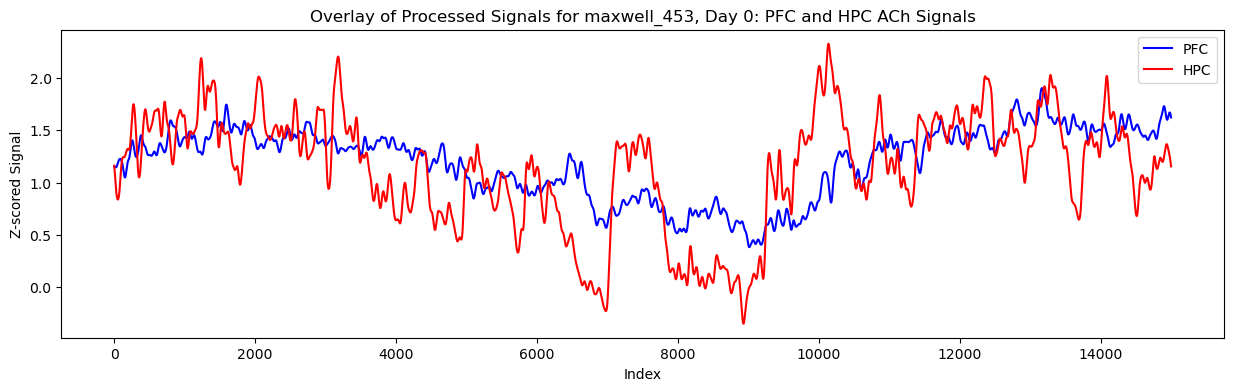

In [8]:
directory = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry'
mouse_id = 'maxwell_453'
day_of_interest = 12
# channel_name = 'Voltage_0 (Filtered)'

# Load data for the specified mouse and day
data = import_photometry_data_for_mouse_and_day(directory, mouse_id, day_of_interest)

# Check if data is loaded successfully
if data is not None:
    # # Process and plot PFC channel
    # process_and_plot_channel(data, 'Voltage_0 (Filtered)', start_index=20000, end_index=50100, sigma=20)
    # 
    # # Process and plot HPC channel
    # process_and_plot_channel(data, 'Voltage_1 (Filtered)', start_index=20000, end_index=50100, sigma=20)
    # Overlaying them
    overlay_processed_signals(data, mouse_id, day_of_interest, start_index=10000, end_index=25000, sigma=20)
else:
    print("Data could not be loaded.")



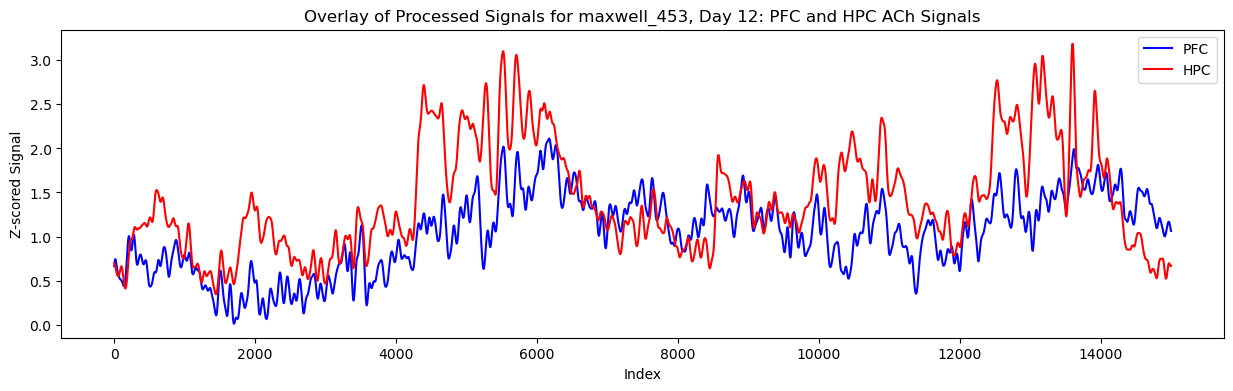

In [9]:
directory = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry'
mouse_id = 'maxwell_453'
day_of_interest = 12
# channel_name = 'Voltage_0 (Filtered)'

# Load data for the specified mouse and day
data = import_photometry_data_for_mouse_and_day(directory, mouse_id, day_of_interest)

# Check if data is loaded successfully
if data is not None:
    # # Process and plot PFC channel
    # process_and_plot_channel(data, 'Voltage_0 (Filtered)', start_index=20000, end_index=50100, sigma=20)
    # 
    # # Process and plot HPC channel
    # process_and_plot_channel(data, 'Voltage_1 (Filtered)', start_index=20000, end_index=50100, sigma=20)
    # Overlaying them
    overlay_processed_signals(data, mouse_id, day_of_interest, start_index=10000, end_index=25000, sigma=20)
else:
    print("Data could not be loaded.")



# TODO: Saving these traces into Dataframes and then pickle them for future use

# Aligning Photometry to Reward signals
This is done --> check the other notebook

# Sampling rates:
- ## demodualted photometry signal sampling rate = 500 Hz
- ## Behaviour sampling rate (from LabView) = 1000 Hz 
## 09/04/2024
- i foudn out the photometry signal sampling rate is actually at 1000 Hz!!

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.stats
from nptdms import TdmsFile
import os
import pandas as pd

def load_and_preprocess_behavior_data(directory_behavior, mouse_id, day_of_interest):
    """
    Loads and preprocesses behavior data from an LVM file for a specific mouse on a specified day.

    Parameters:
    - directory_behavior: The path to the directory containing the LVM files.
    - mouse_id: The ID of the mouse (e.g., 'maxwell_453').
    - day_of_interest: An integer representing the day of interest.

    Returns:
    A DataFrame containing the preprocessed behavior data. If the file does not exist, returns None.
    """
    # Construct file path from the provided parameters
    file_name = f"{mouse_id}_day{day_of_interest}.lvm"
    file_path = os.path.join(directory_behavior, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist.")
        return None

    # Load and preprocess the data
    data = pd.read_csv(file_path, header=None)
    columns = ['time', 'odour_a', 'odour_b', 'odour_c', 'lick_data', 'water_valve', 'NaN1', 'NaN2', 'NaN3']
    data.columns = columns[:len(data.columns)]
    data.drop(['NaN1', 'NaN2', 'NaN3'], axis=1, errors='ignore', inplace=True)

    return data

def align_data(photometry_data, behavior_data, channel_name):
    """
    Aligns photometry data with behavior data based on the shortest length of the datasets.
    
    Parameters:
    - photometry_data: Dictionary containing photometry data.
    - behavior_data: DataFrame containing behavior data.
    - channel_name: The key for the photometry data channel to be aligned.
    
    Returns:
    Tuple of numpy arrays: (aligned_photometry_data, aligned_behavior_data)
    """
    # Extract the photometry signal data for the specified channel
    photometry_signal = photometry_data[channel_name]

    # Determine the aligned length based on the shortest dataset
    aligned_length = min(len(photometry_signal), behavior_data.shape[0])

    # Align both datasets to the same length
    aligned_photometry_data = photometry_signal[:aligned_length]
    aligned_behavior_data = behavior_data.iloc[:aligned_length]

    return aligned_photometry_data, aligned_behavior_data

def find_water_valve_rises(water_valve_signal):
    # Identifying water valve rises from behavior data (NumPy array)
    return np.where(np.diff(water_valve_signal > 2))[0] + 1  # Adding 1 because np.diff reduces the index by 1

def plot_with_rewards(photometry_signals, water_valve_signal, start_index, end_index, sigma):
    """
    Plots the processed photometry signals with vertical lines indicating rewards.
    """
    plt.figure(figsize=(15, 6))

    # Define your channels with their respective colors and labels
    channels = [('Voltage_0 (Filtered)', 'blue', 'PFC'),
                ('Voltage_1 (Filtered)', 'red', 'HPC')]

    for channel_name, color, label in channels:
        # Check if the channel name is in the photometry signals
        if channel_name in photometry_signals:
            # Filter and Z-score the entire signal first
            signal = photometry_signals[channel_name]
            signal_filtered = scipy.ndimage.gaussian_filter1d(signal, sigma=sigma)
            signal_zscored = scipy.stats.zscore(signal_filtered)
            # Now slice the signal for the specified range
            signal_to_plot = signal_zscored[start_index:end_index]
            plt.plot(signal_to_plot, color=color, label=label)

    # Plot reward times as vertical lines
    reward_label_added = False
    water_valve_rises = find_water_valve_rises(water_valve_signal)
    for rise in water_valve_rises:
        if start_index <= rise < end_index:
            plt.axvline(x=rise - start_index, color='g', alpha=0.5, linestyle='-', linewidth=1,
                        label='Reward' if not reward_label_added else "")
            reward_label_added = True

    plt.title(f"Reward and ACh Signal Overlay for Mouse {mouse_id}, Day {day_of_interest}: Comparing PFC and HPC")
    plt.xlabel("Samples")
    plt.ylabel("Z-scored Signal")
    plt.legend()
    plt.show()


#Final calling function
def process_and_plot_photometry(mouse_id, day_of_interest, start_index, end_index, sigma):
    # Load Photometry Data
    directory_photometry = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry'
    photometry_data = import_photometry_data_for_mouse_and_day(directory_photometry, mouse_id, day_of_interest)

    # Load Behavior Data
    directory_behavior = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Behaviour'
    behavior_data = load_and_preprocess_behavior_data(directory_behavior, mouse_id, day_of_interest)

    if photometry_data is not None and behavior_data is not None:
        # Align Data for both HPC and PFC
        aligned_signals = {}
        for channel_name in ['Voltage_0 (Filtered)', 'Voltage_1 (Filtered)']:  # PFC and HPC channels
            aligned_photometry, _ = align_data(photometry_data, behavior_data, channel_name)
            aligned_signals[channel_name] = aligned_photometry

        # Water valve signal after alignment
        water_valve_signal = behavior_data['water_valve'].values[:len(aligned_photometry)]

        # Plot with Rewards for both channels
        plot_with_rewards(aligned_signals, water_valve_signal, start_index, end_index, sigma)
    else:
        print(f"Failed to load data for mouse {mouse_id}, day {day_of_interest}.")


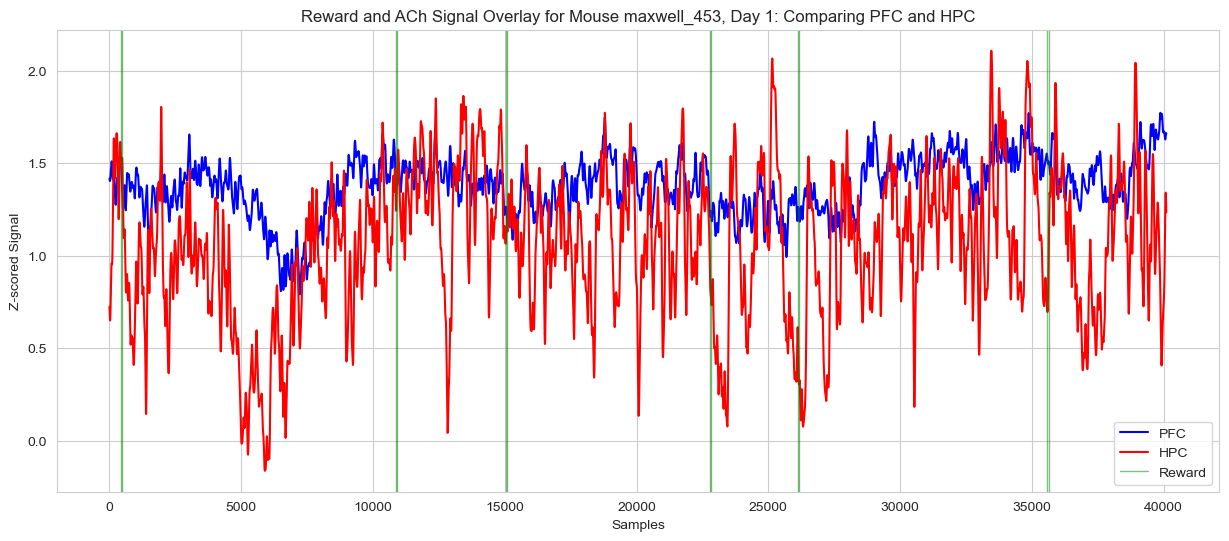

In [12]:
mouse_id = 'maxwell_453'
day_of_interest = 1
start_index=20000
end_index=60100
sigma = 20
process_and_plot_photometry(mouse_id, day_of_interest, start_index, end_index, sigma)

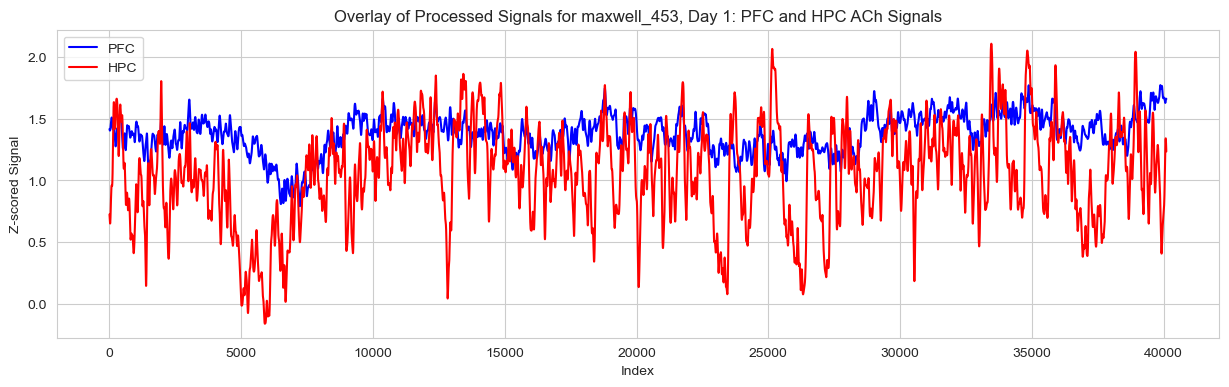

In [13]:
directory = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry'
mouse_id = 'maxwell_453'
day_of_interest = 1
channel_name = 'Voltage_0 (Filtered)'

# Load data for the specified mouse and day
data = import_photometry_data_for_mouse_and_day(directory, mouse_id, day_of_interest)

# Check if data is loaded successfully
if data is not None:
    # # Process and plot PFC channel
    # process_and_plot_channel(data, 'Voltage_0 (Filtered)', start_index=20000, end_index=50100, sigma=20)
    # 
    # # Process and plot HPC channel
    # process_and_plot_channel(data, 'Voltage_1 (Filtered)', start_index=20000, end_index=50100, sigma=20)
    # Overlaying them
    overlay_processed_signals(data, mouse_id, day_of_interest, start_index=20000, end_index=60100, sigma=20)
else:
    print("Data could not be loaded.")



In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.stats
from nptdms import TdmsFile
import matplotlib.pyplot as plt

def import_photometry_data_for_mouse_and_day(directory, mouse_id, day_of_interest):
    filename = os.path.join(directory, f"{mouse_id}_day{day_of_interest}.tdms")
    if not os.path.exists(filename):
        print(f"File {filename} does not exist.")
        return None
    try:
        tdms_file = TdmsFile.read(filename)
    except Exception as e:
        print(f"Failed to read {filename}: {e}")
        return None
    channels_data = {}
    for group in tdms_file.groups():
        for channel in group.channels():
            channels_data[channel.name] = channel[:]
    return channels_data

def load_and_preprocess_behavior_data(directory_behavior, mouse_id, day_of_interest):
    file_name = f"{mouse_id}_day{day_of_interest}.lvm"
    file_path = os.path.join(directory_behavior, file_name)
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist.")
        return None
    data = pd.read_csv(file_path, header=None)
    columns = ['time', 'odour_a', 'odour_b', 'odour_c', 'lick_data', 'water_valve', 'NaN1', 'NaN2', 'NaN3']
    data.columns = columns[:len(data.columns)]
    data.drop(['NaN1', 'NaN2', 'NaN3'], axis=1, errors='ignore', inplace=True)
    return data

def find_water_valve_rises(water_valve_signal):
    return np.where(np.diff(water_valve_signal > 2))[0] + 1

def process_photometry_data_for_mouse(mouse_id, day_of_interest):
    directory_photometry = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Photometry'
    directory_behavior = '/Users/chenx/Desktop/MacAskill Lab/Data/My_Rig_Data/Behaviour'
    sampling_rate = 500  # Hz
    pre_reward_secs = 10
    post_reward_secs = 5

    photometry_data = import_photometry_data_for_mouse_and_day(directory_photometry, mouse_id, day_of_interest)
    behavior_data = load_and_preprocess_behavior_data(directory_behavior, mouse_id, day_of_interest)

    if photometry_data is None or behavior_data is None:
        print(f"Failed to load data for mouse {mouse_id}.")
        return None

    reward_indices = find_water_valve_rises(behavior_data['water_valve'].values)

    pre_reward_points = int(pre_reward_secs * sampling_rate)
    post_reward_points = int(post_reward_secs * sampling_rate)
    baseline_start_points = int((pre_reward_secs - 1.5) * sampling_rate)
    baseline_end_points = pre_reward_points

    ach_signals_mouse = {'PFC': [], 'HPC': []}

    for reward_index in reward_indices:
        start_index = max(reward_index - pre_reward_points, 0)
        end_index = reward_index + post_reward_points
        baseline_start_index = max(reward_index - baseline_start_points, 0)
        baseline_end_index = max(reward_index - baseline_end_points, 0)

        for channel_name in photometry_data:
            if channel_name == 'Voltage_0 (Filtered)':
                area = 'PFC'
            elif channel_name == 'Voltage_1 (Filtered)':
                area = 'HPC'
            else:
                continue

            signal_segment = photometry_data[channel_name][start_index:end_index]
            if len(signal_segment) == pre_reward_points + post_reward_points:
                # Calculate baseline mean, avoiding empty slices
                baseline_segment = photometry_data[channel_name][baseline_start_index:baseline_end_index]
                if len(baseline_segment) > 0:
                    baseline_mean = np.mean(baseline_segment)
                else:
                    baseline_mean = 0  # Default to 0 if no data is available for baseline
                # Subtract baseline mean from the signal segment
                signal_segment_corrected = signal_segment - baseline_mean
                ach_signals_mouse[area].append(signal_segment_corrected)

    return ach_signals_mouse

def across_mice_analysis(mouse_ids, day_of_interest):
    all_signals = { 'PFC': [], 'HPC': [] }

    for mouse_id in mouse_ids:
        mouse_signals = process_photometry_data_for_mouse(mouse_id, day_of_interest)
        if mouse_signals is not None:
            for area in ['PFC', 'HPC']:
                all_signals[area].extend(mouse_signals[area])

    for area in all_signals:
        if all_signals[area]:  # Ensure there are segments to process
            signals = np.vstack(all_signals[area])
            mean_signal = np.mean(signals, axis=0)
            sem_signal = scipy.stats.sem(signals, axis=0)

            plt.figure(figsize=(10, 6))
            time_axis = np.linspace(-pre_reward_secs, post_reward_secs, len(mean_signal))
            plt.plot(time_axis, mean_signal, label=f'{area} Mean Signal Across Mice')
            plt.fill_between(time_axis, mean_signal - sem_signal, mean_signal + sem_signal, alpha=0.2, label=f'{area} SEM Across Mice')

            # Add a vertical red line at 0 seconds for reward onset
            plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Reward Onset')

            plt.title(f'Mean ACh Signal around Rewards for {area} Across Mice for day {day_of_interest}')
            plt.xlabel('Time (s)')
            plt.ylabel('Signal Amplitude')
            plt.legend()
            plt.show()
